In [25]:
import os
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import albumentations as A
from sklearn.model_selection import train_test_split as tts
import time
import matplotlib.pyplot as plt
from IPython.display import display
import random

In [2]:
import kagglehub
dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

In [5]:
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg')):
            image_paths.append(os.path.join(root, file))

In [23]:
for i in image_paths[0:1000]:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [40]:
def populate_whitecard(image_paths, height=1240, width=1754, im_width=250, im_height=250, spacing=10):
    whitecard = np.ones((height, width, 3), dtype=np.uint8) * 255
    x = 10
    y = 10

    diagonal_size = int(np.sqrt(im_width**2 + im_height**2)) + 10

    for i in image_paths:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rot_canvas = np.ones((diagonal_size, diagonal_size, 3), dtype=np.uint8) * 255
        start_x = (diagonal_size - im_width) // 2
        start_y = (diagonal_size - im_height) // 2
        rot_canvas[start_y:start_y + im_height, start_x:start_x + im_width] = img

        rot_angle = random.uniform(-180, 180)
        center = (diagonal_size // 2, diagonal_size // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
        rot_img = cv2.warpAffine(rot_canvas, rot_matrix, (diagonal_size, diagonal_size), borderValue=(255, 255, 255))

        whitecard[y:y+diagonal_size, x:x+diagonal_size] = rot_img
        x += diagonal_size + spacing
        if x > (width-diagonal_size):
            x = 10
            y += diagonal_size + spacing
        if y > (height-diagonal_size):
            return whitecard
    return whitecard

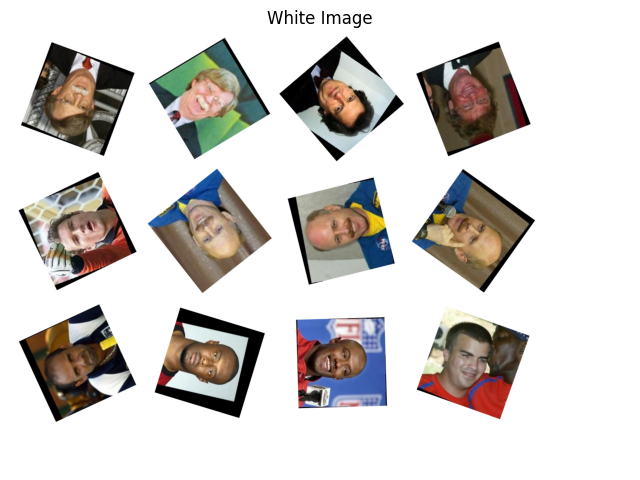

In [43]:
# Define image size (height, width, channels)
height, width = 1240, 1754
white_image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Creates a white image

white_image = populate_whitecard(image_paths[20:50])

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(white_image)
plt.title('White Image')
plt.axis('off')  # Hide axes
plt.show()